**TEAM DETAILS**


Name: **Nithin Goud Kaira**

UBIT name:nithingo

UBIT person number:50469222





Name: **Kavya Sreeja Naidu Motupalli**

UBIT name:kavyasre

UBIT person number:50465235





Name: **Danussh Garlapati**

UBIT name:danusshg

UBIT person number:50477939

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_datasets as tfds
from tqdm import tqdm

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
train_dataset, test_dataset = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

batch_size = 32
shuffle_buffer_size = 10000

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image - 0.5) / 0.5 
    image = tf.image.resize(image, [32, 32]) 
    return image, label


train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, 10)))
train_dataset = train_dataset.shuffle(shuffle_buffer_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, 10)))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


trainloader = tfds.as_numpy(train_dataset)

In [ ]:
testloader = tfds.as_numpy(test_dataset)

In [ ]:
class LeNet5:
  def __init__(self):
    self.BatchNormalization = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.LeakyReLU()
  
  def conv2d_layer(self, filters_in, kernels, padding_valid, x):
    conv_x = tf.layers.conv2d(x, filters = filters_in, padding = padding_valid, kernel_size = kernels, activation=tf.nn.relu)
    return conv_x
  
  def max_pool_conv(self,pool_sizes, stride_size,x):
    conv_pool_x = tf.layers.max_pooling2d(inputs = x, strides = stride_size, pool_size = pool_sizes)
    return conv_pool_x
  
  def fc_flatten(self,x):
    flat_x = tf.layers.flatten(x)
    return flat_x
  
  def fc_dense(self, x, dense_size,activation = None):
    if activation:
      dense_x = tf.layers.dense(inputs = x, units = dense_size)
      return dense_x
    dense_x = tf.layers.dense(inputs = x, units = dense_size, activation=tf.nn.relu)
    return dense_x
  
  def dense_softmax(self,x):
    return tf.nn.softmax(x)

  def build_model(self,input_shape, num_classes):
    inputs = tf.placeholder(dtype=tf.float32, shape=[None, input_shape[0], input_shape[1], input_shape[2]])

    x = self.conv2d_layer(6,[5,5],'valid',inputs)
    x = self.max_pool_conv([2,2],2,x)
    x = self.conv2d_layer(16,[5,5],'valid',x)
    x = self.max_pool_conv([2,2],2,x)
    x = self.fc_flatten(x)
    x = self.fc_dense(x,128)
    x = self.fc_dense(x, 64)

    logits = tf.layers.dense(inputs=x, units=num_classes, activation=None)
    
    preds = tf.nn.softmax(logits)

    labels = tf.placeholder(dtype=tf.int32,shape=[None,num_classes])
    correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    
    
    return optimizer, loss, accuracy, inputs, labels

In [ ]:
lenet = LeNet5()
optimizer, loss, accuracy, inputs, labels = lenet.build_model(input_shape=(32,32,3),num_classes=10)

<ipython-input-4-5f176bd79ea6>:7: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv_x = tf.layers.conv2d(x, filters = filters_in, padding = padding_valid, kernel_size = kernels, activation=tf.nn.relu)
<ipython-input-4-5f176bd79ea6>:11: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  conv_pool_x = tf.layers.max_pooling2d(inputs = x, strides = stride_size, pool_size = pool_sizes)
<ipython-input-4-5f176bd79ea6>:15: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  flat_x = tf.layers.flatten(x)
<ipython-input-4-5f176bd79ea6>:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  dense_x = tf.layers.dense(inputs = x, units = dense_size, activ

In [ ]:
init = tf.global_variables_initializer()
overall_loss = []
overall_acc = []
with tf.Session() as sess:
  sess.run(init)
  for epoch in tqdm(range(10)):
    temp_loss = []
    acc = []
    for images, labels_nn in iter(trainloader):
      _, batch_loss = sess.run([optimizer, loss], feed_dict={inputs: images, labels: labels_nn})
      temp_loss.append(batch_loss / len(labels_nn))
      acc.append(accuracy.eval(feed_dict={inputs: images, labels: labels_nn}))

    n = len(temp_loss)
    overall_loss.append(sum(temp_loss)/n)
    n = len(acc)
    overall_acc.append(sum(acc)/n)

100%|██████████| 10/10 [02:21<00:00, 14.14s/it]


In [ ]:
import matplotlib.pyplot as plt
plt.plot(overall_acc)

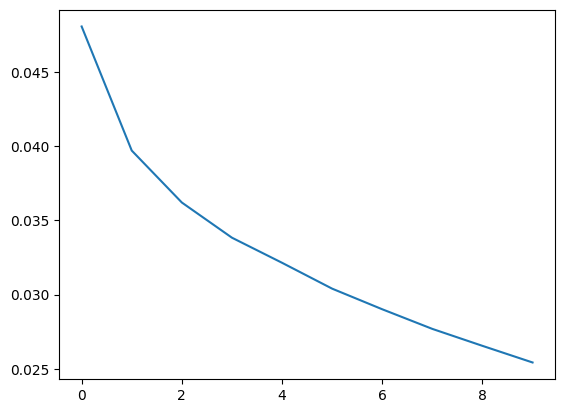

In [ ]:
import matplotlib.pyplot as plt
plt.plot(overall_loss)

In [ ]:
init = tf.global_variables_initializer()
overall_validation_loss = []
overall_validation_acc = []
with tf.Session() as sess:
  sess.run(init)

  for images, labels_nn in iter(testloader):
    _, batch_loss = sess.run([optimizer, loss], feed_dict={inputs: images, labels: labels_nn})
    temp_loss = batch_loss / len(labels_nn)
    acc = accuracy.eval(feed_dict={inputs: images, labels: labels_nn})
    overall_validation_loss.append(temp_loss)
    overall_validation_acc.append(acc)

In [ ]:
plt.plot(overall_validation_loss)

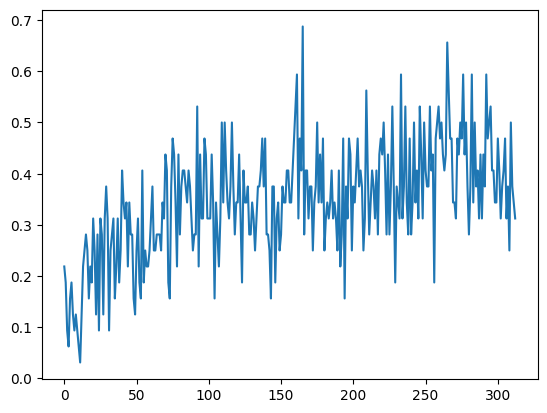

In [ ]:
plt.plot(overall_validation_acc)




***Image augumentation***

In [ ]:
batch_size = 32
shuffle_buffer_size = 10000


train_dataset, test_dataset = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image - 0.5) / 0.5 
    image = tf.image.resize(image, [32, 32]) 
    return image, label


train_dataset = train_dataset.map(lambda x, y: (tf.image.random_flip_up_down(tf.image.random_flip_left_right(x)), y))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, 10)))
train_dataset = train_dataset.shuffle(shuffle_buffer_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, 10)))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)




trainloader = tfds.as_numpy(train_dataset)
testloader = tfds.as_numpy(test_dataset)

In [ ]:
class LeNet5:
  def __init__(self):
    self.BatchNormalization = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.LeakyReLU()
  
  def conv2d_layer(self, filters_in, kernels, padding_valid, x):
    conv_x = tf.layers.conv2d(x, filters = filters_in, padding = padding_valid, kernel_size = kernels, activation=tf.nn.relu)
    return conv_x
  
  def max_pool_conv(self,pool_sizes, stride_size,x):
    conv_pool_x = tf.layers.max_pooling2d(inputs = x, strides = stride_size, pool_size = pool_sizes)
    return conv_pool_x
  
  def fc_flatten(self,x):
    flat_x = tf.layers.flatten(x)
    return flat_x
  
  def fc_dense(self, x, dense_size,activation = None):
    if activation:
      dense_x = tf.layers.dense(inputs = x, units = dense_size)
      return dense_x
    dense_x = tf.layers.dense(inputs = x, units = dense_size, activation=tf.nn.relu)
    return dense_x
  
  def dense_softmax(self,x):
    return tf.nn.softmax(x)

  def build_model(self,input_shape, num_classes):
    inputs = tf.placeholder(dtype=tf.float32, shape=[None, input_shape[0], input_shape[1], input_shape[2]])

    x = self.conv2d_layer(6,[5,5],'valid',inputs)
    x = self.max_pool_conv([2,2],2,x)
    x = self.conv2d_layer(16,[5,5],'valid',x)
    x = self.max_pool_conv([2,2],2,x)
    x = self.fc_flatten(x)
    x = self.fc_dense(x,128)
    x = self.fc_dense(x, 64)

    logits = tf.layers.dense(inputs=x, units=num_classes, activation=None)
    
    preds = tf.nn.softmax(logits)

    labels = tf.placeholder(dtype=tf.int32,shape=[None,num_classes])
    correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    
    
    return optimizer, loss, accuracy, inputs, labels

In [ ]:
lenet = LeNet5()
optimizer, loss, accuracy, inputs, labels = lenet.build_model(input_shape=(32,32,3),num_classes=10)

<ipython-input-13-5f176bd79ea6>:7: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv_x = tf.layers.conv2d(x, filters = filters_in, padding = padding_valid, kernel_size = kernels, activation=tf.nn.relu)
<ipython-input-13-5f176bd79ea6>:11: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  conv_pool_x = tf.layers.max_pooling2d(inputs = x, strides = stride_size, pool_size = pool_sizes)
<ipython-input-13-5f176bd79ea6>:15: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  flat_x = tf.layers.flatten(x)
<ipython-input-13-5f176bd79ea6>:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  dense_x = tf.layers.dense(inputs = x, units = dense_size, a

In [ ]:
init = tf.global_variables_initializer()
overall_loss = []
overall_acc = []
with tf.Session() as sess:
  sess.run(init)
  for epoch in tqdm(range(10)):
    temp_loss = []
    acc = []
    for images, labels_nn in iter(trainloader):
      _, batch_loss = sess.run([optimizer, loss], feed_dict={inputs: images, labels: labels_nn})
      temp_loss.append(batch_loss / len(labels_nn))
      acc.append(accuracy.eval(feed_dict={inputs: images, labels: labels_nn}))

    n = len(temp_loss)
    overall_loss.append(sum(temp_loss)/n)
    n = len(acc)
    overall_acc.append(sum(acc)/n)

100%|██████████| 10/10 [02:30<00:00, 15.07s/it]


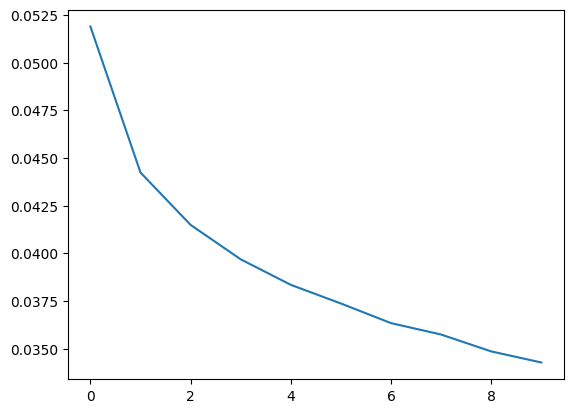

In [ ]:
plt.plot(overall_loss)

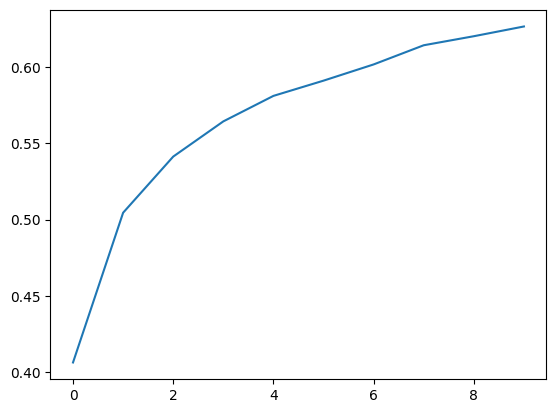

In [ ]:
plt.plot(overall_acc)

In [ ]:
init = tf.global_variables_initializer()
overall_validation_loss = []
overall_validation_acc = []
with tf.Session() as sess:
  sess.run(init)

  for images, labels_nn in iter(testloader):
    _, batch_loss = sess.run([optimizer, loss], feed_dict={inputs: images, labels: labels_nn})
    temp_loss = batch_loss / len(labels_nn)
    acc = accuracy.eval(feed_dict={inputs: images, labels: labels_nn})
    overall_validation_loss.append(temp_loss)
    overall_validation_acc.append(acc)


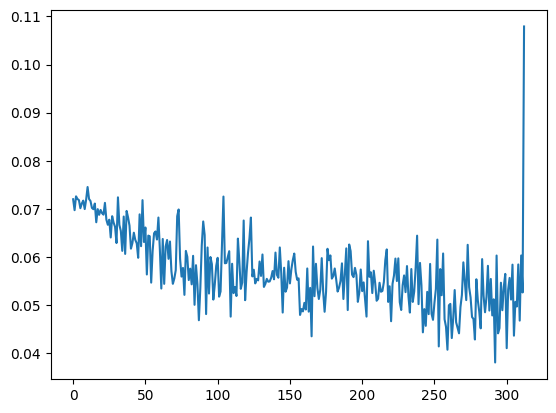

In [ ]:
plt.plot(overall_validation_loss)

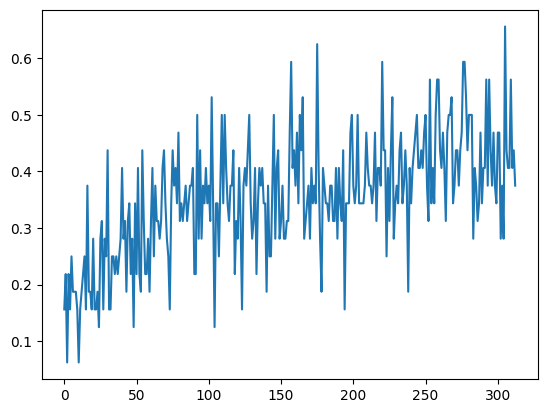

In [ ]:
plt.plot(overall_validation_acc)